# Getting started with Cirq and Honeywell on Azure Quantum

This notebooks shows how to send a basic quantum circuit to a Honeywell target via Azure Quantum.

First, install `azure-quantum` with the Cirq dependencies and import the required packages:

In [1]:
!pip install azure-quantum[cirq]==0.18.2109.165000a1 --extra-index-url=https://pkgs.dev.azure.com/ms-quantum-public/9af4e09e-a436-4aca-9559-2094cfe8d80c/_packaging/alpha/pypi/simple/ --quiet
!pip install matplotlib --quiet

from azure.quantum.cirq import AzureQuantumService

# Plotting
import pylab as pl
%matplotlib inline
pl.rcParams["font.size"] = 16

## Connecting to the Azure Quantum service

To connect to the Azure Quantum service, find the resource ID and location of your Workspace from the Azure Quantum portal here: https://portal.azure.com. Navigate to your Azure Quantum workspace and copy the values from the header.

<img src="copy_resource_id.png">

In [2]:
service = AzureQuantumService(
    resource_id="",
    location="",
    default_target="honeywell.hqs-lt-s1-apival"
)

### List all targets

You can now list all the targets that you have access to, including the current queue time and availability.

In [3]:
service.targets()

[<Target name="ionq.qpu", avg. queue time=196 s, Available>,
 <Target name="ionq.simulator", avg. queue time=2 s, Available>,
 <Target name="honeywell.hqs-lt-s1", avg. queue time=0 s, Unavailable>,
 <Target name="honeywell.hqs-lt-s1-apival", avg. queue time=0 s, Available>,
 <Target name="honeywell.hqs-lt-s2", avg. queue time=0 s, Degraded>,
 <Target name="honeywell.hqs-lt-s2-apival", avg. queue time=0 s, Available>,
 <Target name="honeywell.hqs-lt-s1-sim", avg. queue time=0 s, Available>]

## Run a simple circuit

Now, let's create a simple Cirq circuit to run.

In [10]:
import cirq

q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),             # Hadamard
    cirq.CNOT(q0, q1),              # CNOT
    cirq.measure(q0, q1, key='b') # Measure both qubits
)
circuit

0: ───H───@───M('b')───
          │   │
1: ───────X───M────────

You can now run the program via the Azure Quantum service and get the result. The following cell will submit a job that runs the circuit with 100 shots, wait until the job is completed and return the results.

In [11]:
%%time
result = service.run(program=circuit, repetitions=100)

........CPU times: user 68.2 ms, sys: 4.53 ms, total: 72.7 ms
Wall time: 10.7 s


This returns a `cirq.Result` object. Note that we used the API validator, which only returns zeros.

In [12]:
print(result)

b=0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


Plot the results in a histogram:

Text(0.5, 0, 'Result')

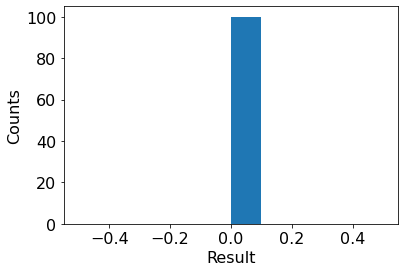

In [13]:
pl.hist(result.data)
pl.ylabel("Counts")
pl.xlabel("Result")

## Asynchronous workflow using Jobs

For long-running circuits, it can be useful to run them asynchronously. The `service.create_job` method returns a `Job`, which you can use to get the results after the job has run successfully.

In [14]:
%%time
job = service.create_job(
    program=circuit,
    repetitions=100
)

CPU times: user 31.2 ms, sys: 262 µs, total: 31.5 ms
Wall time: 475 ms


To check on the job status, use `job.status()`:

In [15]:
job.status()

'Waiting'

To wait for the job to be done and get the results, use the blocking call `job.results()`:

In [16]:
%%time
result = job.results()
print(result)

{'m_b': ['00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00', '00']}
CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 87.4 ms


Note that this does not return a `cirq.Result` object. Instead it returns a dictionary that is specific to the Honeywell simulator.

In [17]:
type(result)

dict